In [0]:
# Name: Shashank Nelamangala Sridhara
# USC ID Number: 2082227554
# USC Email: nelamang@usc.edu
# Submission Date: 04/07/202


!pip install torchvision
!pip install efficientnet_pytorch
from google.colab import drive
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Preprocess the data
trainSet = datasets.CIFAR10("drive/My Drive/EE569-Reports/hw_5", train = True, download = True, 
            transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
testSet = datasets.CIFAR10("drive/My Drive/EE569-Reports/hw_5",  train = False, download = True, 
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
trainImages = torch.utils.data.DataLoader(trainSet, batch_size = 64, shuffle = True, num_workers=2)
testImages = torch.utils.data.DataLoader(testSet, batch_size = 1000, shuffle = True,num_workers=2)




Files already downloaded and verified
Files already downloaded and verified


In [0]:
#To check whether the data is balanced
count = 0
obj_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
for imgs in trainImages:
  Images, labels = imgs
  for l in labels:
    obj_dict[int(l)] += 1
    count +=1
print (obj_dict)


{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


In [0]:
#Build a Neural Network
import torch.nn as nn
import torch.nn.functional as Func
#from efficientnet_pytorch import EfficientNet

class Net(nn.Module):
  def __init__(self, model_name='efficientnet-b0'):
    super(Net, self).__init__()
    #model = EfficientNet.from_pretrained(model_name)
    #self.model = model

    #Defining 2 convolution layers
    self.convotionLayer1 = nn.Conv2d(3, 6, 5)
    self.convotionLayer2 = nn.Conv2d(6, 16, 5)
    #Defining Fully connected Layers (y = Wx + b)
    self.fullyConnected1 = nn.Linear(16 * 5 * 5, 120)
    self.fullyConnected2 = nn.Linear(120, 84)
    self.fullyConnected3 = nn.Linear(84, 10)

  def forward(self, imageFeatures):
    #imageFeatures = self.model.extract_features(imageFeatures)
    imageFeatures = Func.max_pool2d(Func.relu(self.convotionLayer1(imageFeatures)), (2, 2))
    # If the size is a square you can only specify a single number
    imageFeatures = Func.max_pool2d(Func.relu(self.convotionLayer2(imageFeatures)), (2,2))
    imageFeatures = imageFeatures.view(-1, 16*5*5)
    imageFeatures = Func.relu(self.fullyConnected1(imageFeatures))
    imageFeatures = Func.relu(self.fullyConnected2(imageFeatures))
    imageFeatures = self.fullyConnected3(imageFeatures)
    return imageFeatures


cnn = Net()
print(cnn)
params = list(cnn.parameters())
print(len(params))
print(params[0].size())

input = torch.randn(3,3,32,32)
output = cnn(input)
print(output)
labels = torch.randn(10)
labels = labels.view(1, -1) 
criterionFunction = nn.MSELoss()

lossVal = criterionFunction(output, labels)
print(lossVal)






Net(
  (convotionLayer1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (convotionLayer2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fullyConnected1): Linear(in_features=400, out_features=120, bias=True)
  (fullyConnected2): Linear(in_features=120, out_features=84, bias=True)
  (fullyConnected3): Linear(in_features=84, out_features=10, bias=True)
)
10
torch.Size([6, 3, 5, 5])
tensor([[-0.1258,  0.0480,  0.0530,  0.0252, -0.0599, -0.0647,  0.1083,  0.0161,
         -0.1005, -0.0493],
        [-0.1018,  0.0061,  0.0266,  0.0276, -0.0644, -0.0914,  0.0963,  0.0217,
         -0.1070, -0.0465],
        [-0.0883,  0.0554,  0.0133,  0.0514, -0.0811, -0.0482,  0.1090, -0.0033,
         -0.1366, -0.0231]], grad_fn=<AddmmBackward>)
tensor(1.2537, grad_fn=<MseLossBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 10])) that is different to the input size (torch.Size([3, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [0]:
import torch.optim as optim

def evalAccuracy():
  #Overall train and test accuracy
  correctClassification_train = 0
  totalImages_train = 0

  correctClassification_test = 0
  totalImages_test = 0

  with torch.no_grad():
    for data in trainImages:
      img, label = data
      output = cnn(img)
      for i,k in enumerate(output):
        if torch.argmax(k) == label[i]:
          correctClassification_train +=1
        totalImages_train +=1

  with torch.no_grad():
    for data in testImages:
      img, label = data
      output = cnn(img)
      for i,k in enumerate(output):
        if torch.argmax(k) == label[i]:
          correctClassification_test +=1
        totalImages_test +=1

  trainAccuracy = correctClassification_train/totalImages_train      
  testAccuracy = correctClassification_test/totalImages_test
  return trainAccuracy, testAccuracy

def training(learningRate, momentum, epochs, criterion, optimizer):
  trainingAccuracyList = []
  testingAccuracyList = []

  running_loss = 0
  for epoch in range(epochs):
    for i, trainData in enumerate(trainImages, 0):
      imgs, labels = trainData

      #set the gradient to zero
      optimizer.zero_grad()
      outputs = cnn(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
    print(loss)
      
    
    trainAccuracy, testAccuracy = evalAccuracy()
    trainingAccuracyList.append(trainAccuracy)
    testingAccuracyList.append(testAccuracy)

  return trainingAccuracyList, testingAccuracyList

#define training parameters
learningRate = 0.001
momentum = 0.9
epochs = 60
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)


#Call training function
trainingAccuracyList, testingAccuracyList = training(learningRate, momentum, epochs, criterion, optimizer)
print("Train Accuracy for Each Epoch: ",trainingAccuracyList)
print("Test Accuracy for Each Epoch: ", testingAccuracyList)



tensor(1.9084, grad_fn=<NllLossBackward>)
tensor(1.3853, grad_fn=<NllLossBackward>)
tensor(1.4344, grad_fn=<NllLossBackward>)
tensor(1.2847, grad_fn=<NllLossBackward>)
tensor(0.9125, grad_fn=<NllLossBackward>)
tensor(1.4305, grad_fn=<NllLossBackward>)
tensor(1.4858, grad_fn=<NllLossBackward>)
tensor(1.4377, grad_fn=<NllLossBackward>)
tensor(1.6543, grad_fn=<NllLossBackward>)
tensor(1.3827, grad_fn=<NllLossBackward>)
tensor(1.1395, grad_fn=<NllLossBackward>)
tensor(1.8306, grad_fn=<NllLossBackward>)
tensor(1.4313, grad_fn=<NllLossBackward>)
tensor(1.0474, grad_fn=<NllLossBackward>)
tensor(1.3426, grad_fn=<NllLossBackward>)
tensor(1.0456, grad_fn=<NllLossBackward>)
tensor(1.5139, grad_fn=<NllLossBackward>)
tensor(2.0117, grad_fn=<NllLossBackward>)
tensor(1.1155, grad_fn=<NllLossBackward>)
tensor(1.2672, grad_fn=<NllLossBackward>)
tensor(1.4829, grad_fn=<NllLossBackward>)
tensor(1.1345, grad_fn=<NllLossBackward>)
tensor(1.3077, grad_fn=<NllLossBackward>)
tensor(0.8144, grad_fn=<NllLossBac

In [0]:
#Overall train and test accuracy
correctClassification = 0
totalImages = 0

with torch.no_grad():
  for data in testImages:
    img, label = data
    output = cnn(img)
    for i,k in enumerate(output):
      if torch.argmax(k) == label[i]:
        correctClassification +=1
      totalImages +=1

print ("Accuracy: ", correctClassification/totalImages)

Accuracy:  0.4666


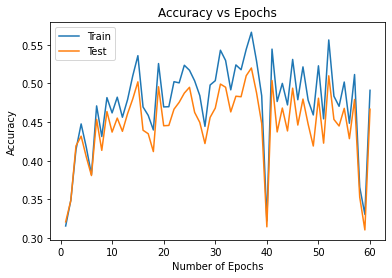

In [0]:
epochList = [i for i in range(1, 61)]
plt.plot(epochList, trainingAccuracyList, label = "Train")
plt.plot(epochList, testingAccuracyList, label = "Test")

plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy')  
plt.title('Accuracy vs Epochs') 
plt.legend()  
plt.show() 

In [0]:
#Accuracy on each Class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testImages:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    if(class_total[i] != 0):
      acc = class_correct[i] / class_total[i]
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 *acc ))
    else:
      print('Accuracy of %5s : %2d %%' % (
          0))

Accuracy of plane : 40 %
Accuracy of   car : 100 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer : 50 %
Accuracy of   dog : 25 %
Accuracy of  frog : 100 %
Accuracy of horse : 33 %
Accuracy of  ship :  0 %
Accuracy of truck : 75 %
